In [1]:
import os
import datetime
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn import metrics

import pickle

# Predictive Analytics SVM Prediction

In [2]:
# read data files for time baskets with size 60, 120, 360 and 1440 min
# grouping via census tract
df_60 = pd.read_parquet(os.path.join("..", "..", "data", "output", "grouped", "df_grouped_60.parquet"))
df_120 = pd.read_parquet(os.path.join("..", "..", "data", "output", "grouped", "df_grouped_120.parquet"))
df_360 = pd.read_parquet(os.path.join("..", "..", "data", "output", "grouped", "df_grouped_360.parquet"))
df_1440 = pd.read_parquet(os.path.join("..", "..", "data", "output", "grouped", "df_grouped_1440.parquet"))

In [3]:
# read data file for time basket with size 60
# grouping via hexagon size 7
df_60_hex_7 = pd.read_parquet(os.path.join("..", "..", "data", "output", "grouped", "df_grouped_60_hex_7.parquet"))

In [4]:
# read data file for time basket with size 60, 120, 360 and 1440 min
# grouping via hexagon size 8
df_60_hex_8 = pd.read_parquet(os.path.join("..", "..", "data", "output", "grouped", "df_grouped_60_hex_8.parquet"))
df_120_hex_8 = pd.read_parquet(os.path.join("..", "..", "data", "output", "grouped", "df_grouped_120_hex_8.parquet"))
df_360_hex_8 = pd.read_parquet(os.path.join("..", "..", "data", "output", "grouped", "df_grouped_360_hex_8.parquet"))
df_1440_hex_8 = pd.read_parquet(os.path.join("..", "..", "data", "output", "grouped", "df_grouped_1440_hex_8.parquet"))

In [5]:
# determine number of unique census tracts
len(df_60["pickup_census_tract"].unique())

388

## Train test split
Since the grouped dataframes use different column names we define different methods to split the data into the training and the test set.
Addionoally we use to methods to reduce the size of the training set. The implementation of the SVR by sklearn works best with a couple of 10.000 samples. The reason for that is the fit time complextiy being more than quadratic with the number of elemnts.

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

- train_test_split_sample: uses random sampling over the whole year
- train_test_split_month: defines june as training and july as test set

In [6]:
def train_test_split_sample(df):
    
    df_sample = df.sample(50000, random_state=42)
    
    df_sample["pickup_census_tract"] = df_sample["pickup_census_tract"].astype('int64')
    df_sample["trip_start_timestamp"] = pd.to_datetime(df_sample["trip_start_timestamp"])
    df_sample["trip_start_hour"] = df_sample["trip_start_timestamp"].dt.hour
    df_sample["trip_start_weekday"] = df_sample["trip_start_timestamp"].dt.weekday
    df_sample["trip_start_month"] = df_sample["trip_start_timestamp"].dt.month
    df_sample["trip_start_week"] = df_sample["trip_start_timestamp"].dt.isocalendar().week
    
    X = df_sample[["trip_start_timestamp", "trip_start_week", "trip_start_month", "trip_start_weekday", "trip_start_hour", "pickup_census_tract"]]
    
    y = df_sample[["trip_count"]]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    
    return X_train, y_train, X_test, y_test

In [7]:
def train_test_split_month(df):
    
    df["pickup_census_tract"] = df["pickup_census_tract"].astype('int64')
    df["trip_start_timestamp"] = pd.to_datetime(df["trip_start_timestamp"])
    df["trip_start_hour"] = df["trip_start_timestamp"].dt.hour
    df["trip_start_weekday"] = df["trip_start_timestamp"].dt.weekday
    
    df_train = df[(df["trip_start_timestamp"].dt.date >= datetime.date(2013, 6, 1)) &
              (df["trip_start_timestamp"].dt.date < datetime.date(2013, 7, 1))]
    
    X_train = df_train[["trip_start_weekday", "trip_start_hour", "pickup_census_tract"]]
    y_train = df_train[["trip_count"]]
    
    df_test = df[(df["trip_start_timestamp"].dt.date >= datetime.date(2013, 7, 1)) &
             (df["trip_start_timestamp"].dt.date < datetime.date(2013, 8, 1))]
    
    X_test = df_test[["trip_start_weekday", "trip_start_hour", "pickup_census_tract"]]
    y_test = df_test[["trip_count"]]
    
    return X_train, y_train, X_test, y_test

In [8]:
def train_test_split_hex(df):
    
    df["trip_start_timestamp"] = pd.to_datetime(df["trip_start_timestamp"])
    df["trip_start_hour"] = df["trip_start_timestamp"].dt.hour
    df["trip_start_weekday"] = df["trip_start_timestamp"].dt.weekday
    
    df_train = df[(df["trip_start_timestamp"].dt.date >= datetime.date(2013, 6, 1)) &
              (df["trip_start_timestamp"].dt.date < datetime.date(2013, 7, 1))]
    
    X_train = df_train[["trip_start_weekday", "trip_start_hour", "hex_ID_pickup"]]
    y_train = df_train[["trip_count"]]
    
    df_test = df[(df["trip_start_timestamp"].dt.date >= datetime.date(2013, 7, 1)) &
             (df["trip_start_timestamp"].dt.date < datetime.date(2013, 8, 1))]
    
    X_test = df_test[["trip_start_weekday", "trip_start_hour", "hex_ID_pickup"]]
    y_test = df_test[["trip_count"]]
    
    return X_train, y_train, X_test, y_test

## Definiton of the training pipeline
Since the training have different features two training pipelines are defined.

- training_pipe_sample: uses the calender week, the month, the weekday, the hour, the weekday and the census tract to predict the trip count
- training_pipe_month: uses the hour, the weekday and the census tract to predict the trip count
- training pipe_hex: similar to training_pipe_month adjusted to hexagons

In [9]:
def training_pipe_sample(regressor):

    numeric_transformer = StandardScaler()

    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # transformation for categorical and numerical features    
    num_feat = ["trip_start_hour"]

    cat_feat = ["trip_start_week", "trip_start_month", "trip_start_weekday", "pickup_census_tract"]
    
    preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, num_feat),
            ('cat', categorical_transformer, cat_feat)])

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', regressor)])

    return pipe

In [10]:
def training_pipe_month(regressor):

    numeric_transformer = StandardScaler()

    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # transformation for categorical and numerical features
    num_feat = ["trip_start_weekday", "trip_start_hour"]

    cat_feat = ["pickup_census_tract"]
    
    preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, num_feat),
            ('cat', categorical_transformer, cat_feat)])

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', regressor)])

    return pipe

In [11]:
def training_pipe_hex(regressor):

    numeric_transformer = StandardScaler()

    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # transformation for categorical and numerical features
    num_feat = ["trip_start_weekday", "trip_start_hour"]

    cat_feat = ["hex_ID_pickup"]
    
    preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, num_feat),
            ('cat', categorical_transformer, cat_feat)])

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', regressor)])

    return pipe

Method to test a trained regression model on the test and training set. The RSME, MAE and R2 score are calcualted.

In [12]:
def test_regression_model(model, X_train, X_test, y_train, y_test):

    y_test_pred = model.predict(X_test)

    y_train_pred = model.predict(X_train)

    train =[]

    train.append(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
    train.append(metrics.mean_absolute_error(y_train, y_train_pred))
    train.append(metrics.r2_score(y_train, y_train_pred))

    test = []

    test.append(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
    test.append(metrics.mean_absolute_error(y_test, y_test_pred))
    test.append(metrics.r2_score(y_test, y_test_pred))

    df = pd.DataFrame(data={'Training set': train, 'Test set': test})
    df.rename(index={0: "RSME", 1:"MAE", 2: "R2"}, inplace=True)

    return df

In [13]:
def gridsearch(model, scoring, C=np.linspace(5,20,5), epsilon=np.linspace(0.25,0.75,5), random_state=42):

    hyperparameter_grid = {
        "regressor__C": C,
        "regressor__epsilon": epsilon,
    }

    grid = GridSearchCV(model, hyperparameter_grid, verbose=2, n_jobs=4, scoring=scoring, cv=KFold(shuffle=True, random_state=random_state))

    return grid

In [14]:
def evaluate_grid(grid, X_train, y_train):

    # fit grid to given data
    grid.fit(X_train, y_train)

    # save result to dataframe
    grid_df = pd.DataFrame(grid.cv_results_["params"])
    grid_df["loss"] = grid.cv_results_["mean_test_score"]

    print(grid.best_params_)

    return grid, grid_df

### Gridsearch
In this gridsearch multiple parameters are tested, due the long running time there are not all combinations within this notebook.

#### Parameters
- spatial unit: census tract or hexagon
- time basket size: 60, 120, 360 and 1440 min
- kernel: linear, rbf and poly

In [44]:
temporal_groups = []
# temporal_groups.append(("hexagon 7", df_60_hex_7))
temporal_groups.append(("60 min", df_60_hex_8))
temporal_groups.append(("120 min", df_120_hex_8))
temporal_groups.append(("360 min", df_360_hex_8))
temporal_groups.append(("1440 min", df_1440_hex_8))

In [45]:
for time, data in temporal_groups:
    
    print("Training models with time basket: " + time)
    
    X_train, y_train, X_test, y_test = train_test_split_hex(data)
    
    models = []
    models.append(("Linear SVR", gridsearch(training_pipe_hex(LinearSVR(random_state=42)), 'neg_mean_absolute_error')))
    models.append(("RBF Kernel", gridsearch(training_pipe_hex(SVR(kernel="rbf")), 'neg_mean_absolute_error')))
    models.append(("Poly Kernel", gridsearch(training_pipe_hex(SVR(kernel="poly")), 'neg_mean_absolute_error')))

    for name, model in models:
        
        print("")
        
        print("Results for " + name)
        
        grid, grid_df = evaluate_grid(model, X_train, y_train.to_numpy().ravel())
    
        result = test_regression_model(grid, X_train, X_test, y_train, y_test)
    
        print(result)
        
    print("----------------------------------------")

Training models with time basket: 60 min

Results for Linear SVR
Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'regressor__C': 16.25, 'regressor__epsilon': 0.75}
      Training set   Test set
RSME     27.184180  27.215354
MAE      12.860357  12.740724
R2        0.531706   0.515896

Results for RBF Kernel
Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'regressor__C': 20.0, 'regressor__epsilon': 0.625}
      Training set   Test set
RSME     14.542569  15.360586
MAE       7.005022   7.506824
R2        0.865980   0.845785

Results for Poly Kernel
Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'regressor__C': 20.0, 'regressor__epsilon': 0.375}
      Training set   Test set
RSME     20.678649  20.843920
MAE       9.700303   9.824176
R2        0.729024   0.716032
----------------------------------------
Training models with time basket: 120 min

Results for Linear SVR
Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'regressor__C'

## Compare Kernels

In [15]:
def compare_models(models, X, y, scoring, figname=None, random_state=42):
    results = []
    names = []

    # evaluate each model in turn
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=random_state, shuffle=True)
        cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Kernel Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    plt.ylabel("MAE")
    ax.set_xticklabels(names)
    plt.show()

In [17]:
models = []
models.append(('Linear SVR', training_pipe_month(LinearSVR(random_state=42))))
models.append(('RBF Kernel', training_pipe_month(SVR(kernel="rbf", C=10.0, epsilon=0.5))))
models.append(('Poly Kernel', training_pipe_month(SVR(kernel="poly", C=10.0, epsilon=0.5))))
models.append(('MLPRegressor', training_pipe_month(MLPRegressor(random_state=42, max_iter=500))))

In [19]:
X_train, y_train, X_test, y_test = train_test_split_month(df_60)

Linear SVR: -8.818070 (0.191223)
RBF Kernel: -5.289615 (0.117478)
Poly Kernel: -6.927355 (0.200413)


C:\Users\Steffen\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Steffen\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Steffen\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Steffen\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Steffen\anaconda3\lib\site-packages\sklearn\neural_netw

MLPRegressor: -5.071495 (0.141220)


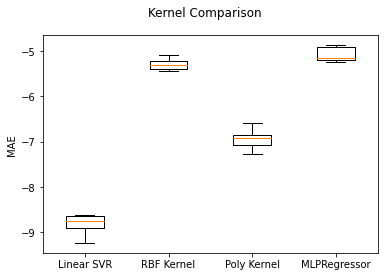

In [20]:
compare_models(models, X_train, y_train.to_numpy().ravel(), 'neg_mean_absolute_error')

## Prediction vs real value

### Training on monthly training set

In [15]:
X_train_month, y_train_month, X_test_month, y_test_month = train_test_split_month(df_60)

In [16]:
model = training_pipe_month(SVR(kernel="rbf", C=10.0, epsilon=0.5))

model.fit(X_train_month, y_train_month.to_numpy().ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['trip_start_weekday',
                                                   'trip_start_hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['pickup_census_tract'])])),
                ('regressor', SVR(C=10.0, epsilon=0.5))])

In [17]:
y_test_month_pred = model.predict(X_test_month)

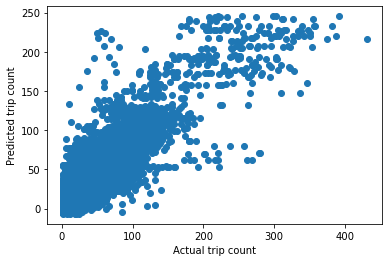

In [32]:
plt.scatter(y_test_month, y_test_month_pred)
plt.xlabel("Actual trip count")
plt.ylabel("Predicted trip count")
plt.show()

In [19]:
df_test = df_60[(df_60["trip_start_timestamp"].dt.date >= datetime.date(2013, 7, 1)) &
             (df_60["trip_start_timestamp"].dt.date < datetime.date(2013, 8, 1))]

In [20]:
df_test["trip_count_pred"] = y_test_month_pred

In [21]:
df_plot = df_test[df_test["pickup_census_tract"] == 17031839100]

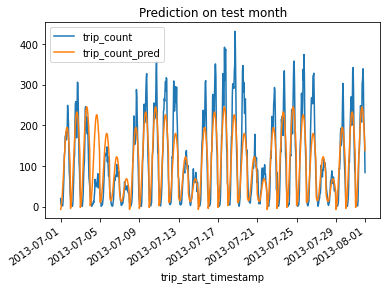

In [41]:
df_plot.plot(x="trip_start_timestamp", y =["trip_count","trip_count_pred"])
plt.xticks(rotation=35)
plt.title("Prediction on test month")
plt.show()

### Training on sample of one year

In [23]:
X_train_sample, y_train_sample, X_test_sample, y_test_sample = train_test_split_sample(df_60)

In [24]:
model = training_pipe_sample(SVR(kernel="rbf", C=20.0, epsilon=0.625))

model.fit(X_train_sample.drop(columns=["trip_start_timestamp"]), y_train_sample.to_numpy().ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['trip_start_hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['trip_start_week',
                                                   'trip_start_month',
                                                   'trip_start_weekday',
                                                   'pickup_census_tract'])])),
                ('regressor', SVR(C=20.0, epsilon=0.625))])

In [25]:
y_test_sample_pred = model.predict(X_test_sample.drop(columns=["trip_start_timestamp"]))

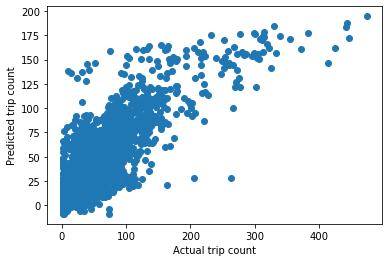

In [33]:
plt.scatter(y_test_sample, y_test_sample_pred)
plt.xlabel("Actual trip count")
plt.ylabel("Predicted trip count")
plt.show()

In [27]:
X_test_sample["trip_count"] = y_test_sample

In [28]:
X_test_sample["trip_count_pred"] = y_test_sample_pred

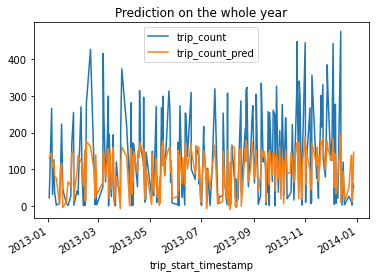

In [40]:
X_test_sample[X_test_sample["pickup_census_tract"] == 17031839100].plot(x="trip_start_timestamp", y=["trip_count", "trip_count_pred"])
plt.title("Prediction on the whole year")
plt.show()

In [30]:
filename = 'complete_year_sample.model'
pickle.dump(model, open(filename, 'wb'))